In [28]:
import jax.numpy as jnp
from pyutils.jax.differential import *
import matplotlib.pyplot as plt

## Brownian with reset

$$dx_t = \mu dt+\sigma dW_t$$

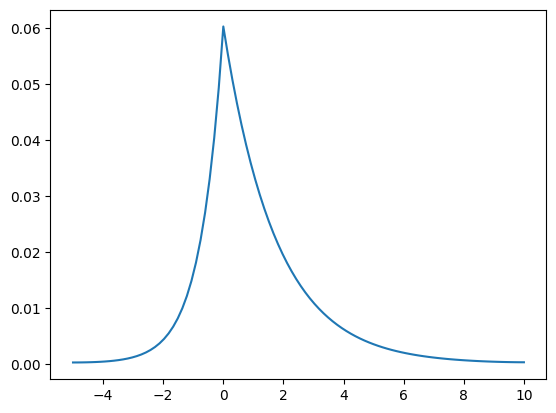

In [64]:
n = 100
x = jnp.linspace(-5,10,n)

mu = 0.1
sigma = 0.5
chi = 0.1

g_entry = jnp.zeros(n)
i = jnp.searchsorted(x, 0)
x_entry = 0
g_entry = g_entry.at[i].set((x_entry -x[i-1])/(x[i]-x[i-1]))
g_entry = g_entry.at[i-1].set((x[i]-x_entry)/(x[i]-x[i-1]))
D_x = compute_backward_derivative(x)
D_xx = compute_second_derivative(x)
g = -jnp.linalg.solve((-D_x*mu - eye(n)*chi + 1/2*D_xx*sigma**2).todense(), chi*g_entry)
fig, ax = plt.subplots()
ax.plot(x,g)
plt.show()

# Ornstein–Uhlenbeck process


$$dx_t = -\theta x_t dt+\sigma dW_t$$

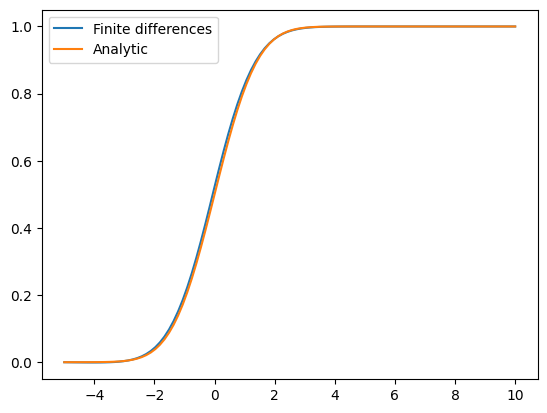

In [108]:
n = 100
x = jnp.linspace(-5,10,n)

theta = 0.1
sigma = 0.5

D_x_forward = compute_backward_derivative(x)
D_x_backward = compute_forward_derivative(x)
D_xx = compute_second_derivative(x)
A = (-D_x_forward@spdiagm(jnp.where(x<0, -theta*x,0)) - D_x_backward@spdiagm(jnp.where(x>0, -theta*x,0)) + 1/2*D_xx*sigma**2).todense()
val, vec = jnp.linalg.eig(A)
g = vec[:,jnp.argmin(jnp.abs(val))]
fig, ax = plt.subplots()
ax.plot(x, jnp.cumsum(g)/jnp.sum(g), label="Finite differences")
ax.plot(x, jax.scipy.stats.norm.cdf(x, 0, jnp.sqrt(sigma**2/(2*theta))), label='Analytic')
plt.legend()
plt.show()